# ADNE 18/19: Trabalho 1
## Urszula Walińska 56556

This tutorial is about Learning from Unstuctured Data methods, designed using Tensorflow and the Keras API (sequential and functional).

__Necessary libraries__<br>
First we need to import all libraries required for this tutorial

In [2]:
from numpy import genfromtxt
import tensorflow as tf
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense, Input
from sklearn.decomposition import PCA
from tensorflow.keras.layers import LeakyReLU
from sklearn.model_selection import StratifiedKFold

__Logistic regression using Tensorflow__<br>
We will start with solving a binary classification problem with building logistic regression model using Tensorflow.

The function that approximates probability of the example belonging to the class $C_1$ is sigmoid:
$$g(x, w) = \frac{1}{1+e^{-wx + w_0}}$$
When fitting regression model we are trying to approximate continuous probability function threshold which indicates the fact of belonging to class or not. In order to solve the problem, we need to maximize likelihood, which is the probability of the data given the hyphotesis. In binary classification the maximum likelihood solution can be find by minimizing logistic loss:
$$ E(w) = -\frac{1}{N} \sum_{n=1}^N[t_n ln(g_n) + (1 - t_n) ln(1-g_n)] $$
*Maximizing likelihood equals minimizing cross-entopy.

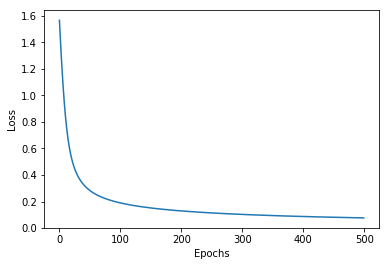

In [32]:
# load data
mat = np.loadtxt('T01/gene_data.txt',delimiter='\t')

# we need to normalize data by subtracting the mean and divide by standard deviation
# normalizing prevents from the problem, in which different scales force to adjust weights at different rates 
Ys = mat[:,[-1]].astype(np.float32)
Xs = mat[:,:-1].astype(np.float32)
means = np.mean(Xs,0)
stdevs = np.std(Xs,0)
Xs = (Xs-means)/stdevs

# creating constants representing our data in the model
X = tf.constant(Xs.astype(np.float32), name="X")
y = tf.constant(Ys.astype(np.float32), name="y")

# creating variables which will be our weights (bias is w0)
# initialize variables using gaussian distribution giving a shape of variables -> w1, w2
# (not to optimize everytime in the same way)
weights = tf.Variable(tf.random_normal((2,1)), name="weights")
bias = tf.Variable(0.0, name="bias")

net = tf.add(tf.matmul(X, weights), bias, name="net")

# finally, g(x,w) = sigmoid(X * weights + bias)
output = tf.nn.sigmoid(net, name="output")

# logistic loss to minimize 
cost = -tf.reduce_mean(y * tf.log(output) + (1-y) * (tf.log(1-output)))

# after creating a cost function, we need to specify the gradient optimizer
# that will minimize it and find desired values of weights
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
training_op = optimizer.minimize(loss=cost)
init = tf.global_variables_initializer()

data_to_plot = []
num_of_epochs = 500

# within a session we will be running initialization first
# and then in each epoch we will change the values of weights
# by minimizing cost function
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_of_epochs):
        _, cost_value = sess.run([training_op, cost])
        data_to_plot.append(cost_value)
        
    final_w = weights.eval()
    final_b = bias.eval()
    sess.close()

plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(data_to_plot)
plt.show()

In [47]:
print(final_b)
print(final_w)

-1.0763233
[[-2.3672476]
 [-2.7421942]]


On the plot presented above we can see how the loss decreases in each epoch. Finally, we obtained following weights: $w = [-1.08, -2.37, -2.74]$.<br>
Below, the visualisation of decision boundry was presented.

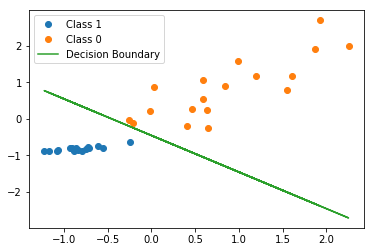

In [48]:
mask_true = Ys[:,0] == 1
mask_false = Ys[:,0] == 0

plt.plot(Xs[mask_true,0], Xs[mask_true,1], "o", label='Class 1')
plt.plot(Xs[mask_false,0], Xs[mask_false,1], "o", label='Class 0')

x_values = Xs[:,0]
y_values = - (final_b + final_w[0] * x_values) / final_w[0]

plt.plot(x_values, y_values, label='Decision Boundary')
plt.legend()
plt.show()

We could obtain the same result using one Perceptron with sigmoid as an activation function, because these are equivalent and allow only linear combination of the features. If we stack more layers, we obtain Multi Layer Perceptron, in which hidden layers transform the features to be lineary separable.

__Multi Layer Perceptron for binary classification problem__

Multi Layer Perceptron is fully connected, feed-forward network, in which each neuron receives as input the output of all neuros from previous layer. We will use now a Multi Layer Perceptron for the same problem as before.

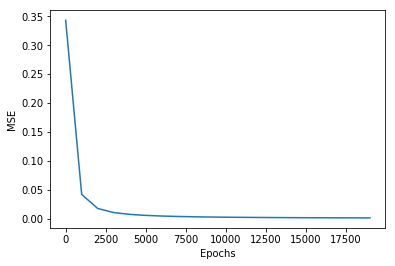

In [52]:
# we need to start with creating a function for creating layers in our network
# arguments: input for the layer, number of neurons in the layer and the name
# each layer would result in:
# output = sigmoid(inputs * weights + bias)
def create_layer(inputs,neurons,name):
    with tf.name_scope(name):
        weights = tf.Variable(tf.random_normal((int(inputs.shape[1]),neurons)), name="weights")
        bias = tf.Variable(tf.zeros([neurons]), name="bias")
        net = tf.add(tf.matmul(inputs, weights), bias, name="net")
        output = tf.nn.sigmoid(net, name="output")
    return output

# if we want we can track our progress using tensorboard
# here is tensorboard setup
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "logs"
logdir = "{}/model-{}/".format(root_logdir, now)

# we need to reset our default graph each time 
tf.reset_default_graph()

# we create 2 layers:
# - one hidden layer with 2 neurons
# - one output layer with 1 neuron
layer1 = create_layer(Xs,2,'layer1')
layer2 = create_layer(layer1,1,'layer2')

# our cost function would be mean squared error this time
# and we want to reduce it as before using gradient descent optimizer
mse = tf.reduce_mean(tf.square(Ys-layer2),name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
training_op = optimizer.minimize(loss=mse)
init = tf.global_variables_initializer()

# tensorboard summarization
# to be able to see the progress of MSE during our training
cost_summary = tf.summary.scalar('MSE',mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

data_to_plot_X = []
data_to_plot_Y = []
num_of_epochs = 20000

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_of_epochs):
        cost, _ = sess.run((mse,training_op))
        if epoch%1000 == 0:
            data_to_plot_X.append(epoch)
            data_to_plot_Y.append(cost)
            file_writer.add_summary(cost_summary.eval(), epoch)

file_writer.close()

plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.plot(data_to_plot_X, data_to_plot_Y)
plt.show()

Just like before, we can observe the decrease of cost function in each epoch. This time cost function is defined as a mean squared error.

Here is a result in tensorboard of tracking MSE value:
![](tensor1.PNG)

Tensorboard also automatically creates the graph of our model. In this case it looks like that:
![](tensor2.PNG)

__Neural Network for multi-class classification__

This time, we have a different problem to solve, which is a multi-class classification. In our case we would like to classify handwritten digits. In order to solve the problem we will have to transform a bit our previous model.

Final accuracy: 0.8302


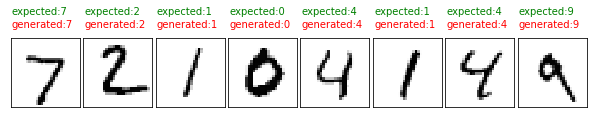

In [29]:
# modified function for creating layers
# the last argument is an activation function 
# we would like to apply to the neurons in layer
def create_layer1(inputs,neurons,name,activation_fun=None):
    with tf.name_scope(name):
        weights = tf.Variable(tf.random_normal((int(inputs.shape[1]),neurons)), name="weights")
        bias = tf.Variable(tf.zeros([neurons]), name="bias")
        if activation_fun:
            net = tf.add(tf.matmul(inputs, weights), bias, name="net")
            return activation_fun(net, name="output")
        else:
            return tf.add(tf.matmul(inputs, weights), bias, name="output")

# load data (labels are the true classes)
# it is already divided into train set and test set 
# using which we will evaluate our results 
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images_in, test_labels) = mnist.load_data()

# divide train set into train and validation sets
# evaluating result of learning on validation set after each epoch
# will help us to prevent from overfitting
valid_images = train_images[50000:].reshape(-1,28*28)
valid_labels = train_labels[50000:]
train_images = train_images[:50000].reshape(-1,28*28)
train_labels = train_labels[:50000]
test_images = test_images_in.reshape(-1,28*28)

num_features = 784 # 28 * 28
num_labels = 10

features = tf.placeholder(tf.float32, shape=(None, num_features))
labels = tf.placeholder(tf.int64, shape=(None))

# transforming the labels into a proper representation for learning
one_hot_labels = tf.one_hot(labels, depth = num_labels,
on_value = 1.0, off_value = 0.0, axis = -1)

# creating a network consisting of 2 hidden layers
# and output layer with 10 neurons because we have 10 classes
layer0 = create_layer1(features,10,'layer0', tf.nn.sigmoid)
layer1 = create_layer1(layer0,20,'layer1', tf.nn.sigmoid)
layer2 = create_layer1(layer1,10,'layer2')

num_epochs = 50
# learning rate decides how fast the parameters of our model will change
learning_rate = 0.0015
batch_size = 10

# this time our cost function is softmax cross entropy
# softmax is a function that approximates the probability of belonging to each of n classes
# minimizing cross entropy equals maximizing the likelihood of our data being as it is???
loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(
onehot_labels=one_hot_labels,
logits=layer2))
# we will use RMSPropOptimizer this time
# thanks to it, we will be able to solve the problem of preventing optimizer from adapting to different conditions 
# (when the learning rate is constant)
# this optimizer also accumulates the previous gradients directions
# to prevent from problems with algorithm convergence
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# tf.nn.softmax computes softmax activations to be able to read class probabilities
class_probabilities = tf.nn.softmax(layer2)
# the final (most probable) prediction
prediction = tf.argmax(class_probabilities,axis=1)
# computing the accuracy taking into consideration our prediction and original labels
accuracy = tf.reduce_mean(tf.cast(tf.equal(labels,prediction), tf.float32))

# to be able to learn in batches we have to shuffle our data first
shuffled = np.array(range(train_images.shape[0]))

data_to_plot = []

with tf.Session() as session:
    tf.global_variables_initializer().run()
    
    for epoch in range(num_epochs):
        offset = 0
        np.random.shuffle(shuffled)
        
        # training in batches
        while offset < train_images.shape[0]:
            batch_images = train_images[shuffled[offset:offset+batch_size]]
            batch_labels = train_labels[shuffled[offset:offset+batch_size]]
            batch_dict = {features : batch_images, labels : batch_labels}
            session.run([optimizer], feed_dict=batch_dict)
            offset += batch_size
        
        # after whole epoch, we evaluate results by computing value of accuracy on validation set
        acc_dict = {features : valid_images, labels : valid_labels}
        acc = session.run([accuracy], feed_dict=acc_dict)
        data_to_plot.append(acc[0])
        
    # we also check the final accuracy we achieved
    acc_dict = {features : test_images, labels : test_labels}
    acc, pred = session.run([accuracy, prediction], feed_dict=acc_dict)
    print("Final accuracy:", acc)
    
    # visualising first 8 predicted examples from test set
    fig = plt.figure(figsize=(8, 8))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    cnt = 0
    for i in range(8):
        ax = fig.add_subplot(8, 8, cnt + 1, xticks=[], yticks=[])
        plt.imshow(test_images_in[cnt].reshape(28, 28),cmap='Greys')
        cnt += 1

        ax.text(0, -5, "generated:" + str(pred[i]), color='red')
        ax.text(0, -10, "expected:" + str(test_labels[i]), color='green')

As we can see our final accuracy evaluated on separated test data is 83%, which is quite good result. We have also obtained a membership to the classes predicted for the examples from test data, which are visualised on the plot above. As we can see our algorithm performed well on the chosen examples, generated class equals expected in each case.

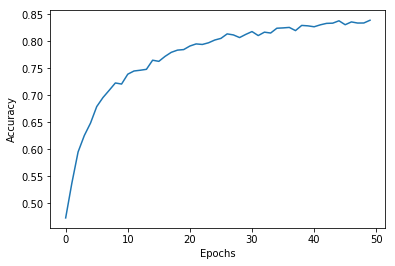

In [35]:
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.plot(data_to_plot)
plt.show()

However, as we look at the plot of accuracy on the validation set over the epochs, we can notice some problems with convergence of our algorithm (the line fluctuates mildly). Possibly, the learning rate is still too high.

__Dense Neural Network design using Keras Sequential API and 10-fold cross validation using StratifiedKFold from sklearn library__

In this problem of binary classification, we would like to focus on cross validation method. It enables us to notice is our model is overfitting, which means it is prone to fit to irrelevant details and is not able to generalize. In cross validation, we split our training data set into k disjoint folds. Then we train our model using k - 1 of them and use one of them for validation. Then we repeat this process leaving another fold for validation and in the end we average the validation error.

In [7]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# load dataset
dataset = np.loadtxt("pima-indians-diabetes.data.csv", delimiter=",")
X = dataset[:,0:8]
Y = dataset[:,8]

# define 10-fold cross validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []

for train, test in kfold.split(X, Y):
    # create model
    # Keras Sequential API makes creating model simple
    # our model will consist of 3 Dense layers, 2 of them with ReLu activation function, 
    # which prevents from the problem of vanishing gradients
    # and the last layer with sigmoid activation function for binary classification
    model = Sequential()
    model.add(Dense(12, input_dim=8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    
    # we evaluate model's accuracy on validation fold
    scores = model.evaluate(X[test], Y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)

# calculate averaged validation accuracy
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

acc: 76.62%
acc: 75.32%
acc: 62.34%
acc: 76.62%
acc: 71.43%
acc: 77.92%
acc: 64.94%
acc: 70.13%
acc: 71.05%
acc: 68.42%
71.48% (+/- 4.97%)


As we can see, in each iteration using different validation fold we obtain different accuracy. In the end we obatin the final averaged validation accuracy equal 71%.

__Convolutional and Dense Neural Network design using Keras Sequential API__

This time we also want to solve a problem of multi-class classification but with different data set. It will be classification of types of clothing. We will also use several Convolutional layers in our model. Formally, convolution is:
$$(f*g)(t) = \int_{-\infty}^\infty f(\tau)g(t-\tau) \,d\tau$$
The scheme of the way it works is presented below:
![sf](http://deeplearning.stanford.edu/wiki/images/6/6c/Convolution_schematic.gif)
It is a result of applying an exemplary filter to the image. Filters are supposed to extract relevant features (sometimes hidden) from the image.

In [8]:
# load data (X sets are images and Y sets are the true classes of the examples)
# just like before, it is already divided into train set and test set 
# so that we can evaluate our results 
((trainX, trainY), (testX, testY)) = keras.datasets.fashion_mnist.load_data()

# data pre-processing
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

# one-hot encode the training and testing labels
trainY = keras.utils.to_categorical(trainY, 10)
testY = keras.utils.to_categorical(testY, 10)

def create_model():
    model = Sequential()
    
    # Convolutional Layer with 32 filters, kernel of size (3,3), 
    # "same" padding which results in the output with the same length as the original input, 
    model.add(Conv2D(32, (3, 3), padding="same", input_shape=(28,28,1)))
    # ReLU activation function 
    model.add(Activation("relu"))
    # Batch Normalization to force each layer to readjust mean and standard deviation after each iteration
    model.add(BatchNormalization(axis=-1))
    
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))
    
    # MaxPooling of size (2,2) to aggregate the outputs in a single output for each region
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Dropout with the probability of 0.25 for regularization -> some neurons are dropped randomly
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))
    
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # in the end we attach dense network to perform classification
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    # 10 neurons in the output layer with softmax for 10-class classification, as before
    model.add(Dense(10))
    model.add(Activation("softmax"))
    
    return model

INIT_LR = 0.01
NUM_EPOCHS = 2
BS = 10

model = create_model()
# definition of optimizer -> Stochastic Gradien Descent, but with decaying of learning rate
opt = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# we can pass as a parameter of validation data 
# to evaluate our results on different data set than the one used for training
history = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=BS, epochs=NUM_EPOCHS)
print(history.history)

# saving weights and model to be able to use it later
model.save_weights('fashion_model_my1.h5')
model_json = model.to_json()
with open("fashion_model_my1.json", "w") as json_file:
     json_file.write(model_json)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 768s 13ms/sample - loss: 0.7337 - acc: 0.7631 - val_loss: 0.4329 - val_acc: 0.8480
Epoch 2/2
60000/60000 [==============================] - 782s 13ms/sample - loss: 0.5255 - acc: 0.8131 - val_loss: 0.3989 - val_acc: 0.8566
{'loss': [0.7337063153823837, 0.525531029826651], 'acc': [0.76305, 0.81315], 'val_loss': [0.4329267003275454, 0.3988926092842594], 'val_acc': [0.848, 0.8566]}


The output above presents the results after each epoch. The accuracy on train set after whole process of learning reached 81% and on validation set it reached 86%.

__Transfer Learning using Keras Functional API__

We can take advantage from the model trained and saved before in the similar multi classification problem. This process is called Transfer Learning. It is used when 2 different tasks share relevant factors. In this case we will use the previous model build for classifying clothes to classify digits.

In [34]:
# data pre-processing as before
((trainX, trainY), (testX, testY)) = keras.datasets.mnist.load_data()
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

# one-hot encode the training and testing labels
trainY = keras.utils.to_categorical(trainY, 10)
testY = keras.utils.to_categorical(testY, 10)

# the architecture of network is the same as in previous problem to be able to load weights
# but this time it is designed using Functional Keras API
inputs = Input(shape=(28,28,1),name='inputs')
layer = Conv2D(32, (3, 3), padding="same", input_shape=(28,28,1))(inputs)
layer = Activation("relu")(layer)
layer = BatchNormalization(axis=-1)(layer)
layer = Conv2D(32, (3, 3), padding="same")(layer)
layer = Activation("relu")(layer)
layer = BatchNormalization(axis=-1)(layer)
layer = MaxPooling2D(pool_size=(2, 2))(layer)
layer = Dropout(0.25)(layer)
layer = Conv2D(64, (3, 3), padding="same")(layer)
layer = Activation("relu")(layer)
layer = BatchNormalization(axis=-1)(layer)
layer = Conv2D(64, (3, 3), padding="same")(layer)
layer = Activation("relu")(layer)
layer = BatchNormalization(axis=-1)(layer)
layer = MaxPooling2D(pool_size=(2, 2))(layer)
layer = Dropout(0.25)(layer)

features = Flatten(name='features')(layer)
layer = Dense(512)(features)
layer = Activation("relu")(layer)
layer = BatchNormalization()(layer)
layer = Dropout(0.5)(layer)
layer = Dense(10)(layer)
layer = Activation("softmax")(layer)
old_model = Model(inputs = inputs, outputs = layer)

INIT_LR = 0.01
NUM_EPOCHS = 2
BS = 10

opt = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
old_model.compile(optimizer=SGD(), loss='mse')

# using weights from previous task
old_model.load_weights('fashion_model_my1.h5')

# prevent the layers from previous model from training
for layer in old_model.layers:
    layer.trainable = False

# attaching new dense network to the previous convolution network
layer = Dense(512)(old_model.get_layer('features').output)
layer = Activation("relu")(layer)
layer = BatchNormalization()(layer)
layer = Dropout(0.5)(layer)
layer = Dense(10)(layer)
layer = Activation("softmax")(layer)
model = Model(inputs = old_model.get_layer('inputs').output, outputs = layer)

opt = SGD(lr=1e-2, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
model.summary()

NUM_EPOCHS = 5
BS=512

# using the obtained model to fit into new data
H = model.fit(trainX, trainY,validation_data=(testX, testY), batch_size=BS, epochs=NUM_EPOCHS)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation_14 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_v1_6 (Ba (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_15 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_v1_7 (Ba (None, 28, 28, 32)        128       
__________

In [36]:
scores = model.evaluate(testX, testY, batch_size=BS)

10000/10000 [==============================] - 9s 883us/sample - loss: 0.0938 - acc: 0.9696


As we can see, we managed to reduce slightly the number of trainable parameters by using model built for the previous problem. Even though we managed to achieve the accuracy on test set equal 97%.

__Autoencoder using Keras Functional API__

Autoencoders are networks trained to output the input, so it is unsupervised learning. In our case, using autoencoder we would like to lower the dimension to capture structure in the data. We want to represent data on the plane in a way that separates 2 classes of banknotes (false and true ones). Because of the fact that we would like to lower the dimension, we have to build an undercomplete autoencoder.

In [41]:
mat = genfromtxt('T01/banknotes.csv', delimiter=',')

trainY = mat[:,[-1]].astype(np.float32)
X = mat[:,:-1].astype(np.float32)
means = np.mean(X,0)
stdevs = np.std(X,0)
trainX = (X-means)/stdevs

inputs = Input(shape=(4,),name='inputs')
layer = Dense(16)(inputs)
layer = Activation(LeakyReLU())(layer)
layer = Dense(8)(layer)
layer = Activation(LeakyReLU())(layer)
# we capture the 2-dimensional representation of our data
layer = Dense(2, name='encoded')(layer)
layer = Activation(LeakyReLU())(layer)
layer = Dense(8)(layer)
layer = Activation(LeakyReLU())(layer)
layer = Dense(16)(layer)
layer = Activation(LeakyReLU())(layer)
layer = Dense(4)(layer)
layer = Activation("linear")(layer)
model = Model(inputs = inputs, outputs = layer)

opt = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
model.compile(loss="mean_squared_error", optimizer=opt)
NUM_EPOCHS = 50
BS=512
H = model.fit(trainX, trainY, batch_size=BS, epochs=NUM_EPOCHS)

Epoch 1/50
1372/1372 [==============================] - 1s 435us/sample - loss: 0.4231
Epoch 2/50
1372/1372 [==============================] - 0s 4us/sample - loss: 0.3968
Epoch 3/50
1372/1372 [==============================] - 0s 5us/sample - loss: 0.3534
Epoch 4/50
1372/1372 [==============================] - 0s 7us/sample - loss: 0.3097
Epoch 5/50
1372/1372 [==============================] - 0s 7us/sample - loss: 0.2738
Epoch 6/50
1372/1372 [==============================] - 0s 6us/sample - loss: 0.2511
Epoch 7/50
1372/1372 [==============================] - 0s 5us/sample - loss: 0.2411
Epoch 8/50
1372/1372 [==============================] - 0s 10us/sample - loss: 0.2358
Epoch 9/50
1372/1372 [==============================] - 0s 7us/sample - loss: 0.2318
Epoch 10/50
1372/1372 [==============================] - 0s 5us/sample - loss: 0.2263
Epoch 11/50
1372/1372 [==============================] - 0s 9us/sample - loss: 0.2190
Epoch 12/50
1372/1372 [==============================] - 0s 

__Dimension reduction using encoder vs using PCA__

To be able to evaluate the quality of our dimension reduction, we will compare it with the other method suitable for this purpose, which is called PCA.

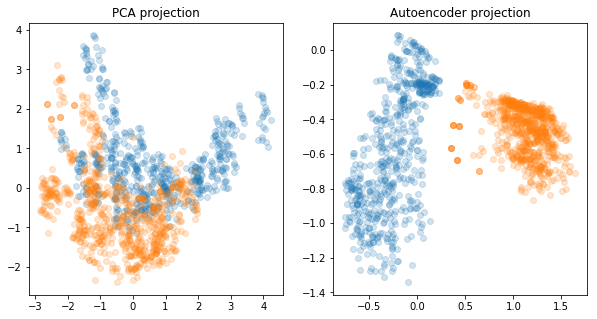

In [42]:
mask_true = trainY[:,0] == 1
mask_false = trainY[:,0] == 0

# using PCA for data projection
pca = PCA(n_components=2)
pca_result = pca.fit_transform(trainX)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('PCA projection')
plt.plot(pca_result[mask_true,0], pca_result[mask_true,1], "o", alpha=0.2)
plt.plot(pca_result[mask_false,0], pca_result[mask_false,1], "o", alpha=0.2)

# using the output of encoder from previously built autoencoder for dimension reduction
# in a way to be able to distinct fake banknotes from the true ones
encoder = Model(inputs = inputs, outputs = model.get_layer('encoded').output)
encoded = encoder.predict(trainX)

plt.subplot(1,2,2)
plt.title('Autoencoder projection')
plt.plot(encoded[mask_true,0], encoded[mask_true,1], "o", alpha=0.2)
plt.plot(encoded[mask_false,0], encoded[mask_false,1], "o", alpha=0.2)

plt.show()

As we can see, using trained encoder for obtaining 2-dimensional representation of the data, we have managed to separate the 2 classes of banknotes completely. On the contrary, we can easily notice that PCA projection did not separate these 2 classes.